In [1]:
import numpy as np
import pandas as pd
import yaml
import os
os.chdir('/workspace') # change to the root directory of the project

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import accuracy_score, r2_score, mean_squared_error, roc_curve, roc_auc_score, jaccard_score

from utils import maldi_normalize

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")

# Load the data

In [4]:
# Load the MSI data
peaks = pd.read_pickle('data/MALDI_IHC/peaks.pkl')
peaks_pqn = pd.read_pickle('data/MALDI_IHC/peaks_normalized.pkl')
pixels = pd.read_pickle('data/MALDI_IHC/pixels.pkl')

# Define the densities and a threshold for each pixel density

In [3]:
# Determine the densities of the selected pixels
densities = [col for col in pixels.columns if 'Density' in col][2:]

# Get the number of lames and densities
lames = pixels['run'].unique()
n_lames = len(lames)

# Define the threshold for each density
threshold = {
    'Density_CD8': 0.03,
    'Density_Tumor': 0.1,
    'Density_Stroma': 0.8,
    'Density_Collagen': 0.5
    }

In [10]:
# Noramlize the peaks using PQN
peaks_norm = peaks.copy()
for lame in lames:
    peaks_norm[pixels['run'] == lame] = maldi_normalize(peaks[pixels['run'] == lame])

In [23]:
peaks

,500.286,501.2936,502.2799,503.2801,504.2635,505.2599,506.2362,507.351,508.2527,509.2492,...,3597.2011,3597.7125,3597.821,3598.1119,3598.3979,3598.7677,3599.1398,3599.3676,3599.6829,3599.8216
0,1.485,2.330,1.565,2.855,2.345,0.875,1.170,0.405,0.735,1.145,...,0.30,0.47,0.47,0.13,0.22,0.25,0.22,0.25,0.52,0.52
1,1.025,1.375,1.680,1.660,1.340,1.375,0.460,1.330,0.700,0.740,...,0.20,0.25,0.25,0.31,0.29,0.29,0.00,0.00,0.00,0.00
2,0.270,0.240,0.455,0.375,1.330,1.300,0.330,0.965,0.775,0.750,...,0.24,0.29,0.35,0.55,0.00,0.00,0.00,0.00,0.00,0.00
3,0.780,0.725,0.560,1.680,1.160,1.180,0.590,0.870,0.800,1.090,...,0.48,0.23,0.39,0.31,0.62,0.66,0.47,0.32,0.70,0.70
4,0.740,2.075,3.980,2.500,1.925,0.735,1.830,0.385,1.920,1.430,...,0.36,0.56,0.56,0.25,0.50,0.41,0.25,0.25,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1616360,1.750,1.895,1.790,1.190,1.240,1.785,1.230,1.560,1.890,1.650,...,0.92,0.89,0.89,1.00,1.05,1.13,1.01,0.89,1.07,1.03
1616361,1.740,2.200,1.630,2.030,1.340,1.140,1.255,1.935,2.365,1.865,...,1.11,1.09,1.04,1.14,1.11,0.99,1.15,0.93,1.16,0.99
1616362,1.570,2.305,2.485,2.630,3.010,2.585,2.120,1.485,1.975,2.335,...,1.15,0.99,0.99,0.93,1.04,1.00,0.97,0.90,0.99,0.99
1616363,2.100,2.460,2.355,2.420,2.550,1.945,2.045,1.680,2.030,2.150,...,0.90,1.07,1.06,0.96,0.97,1.16,0.99,0.93,1.09,0.98


In [46]:
image = peaks[pixels['run'] == lames[1]].iloc[:, 2000:].mean(axis=1)
image_pqn = peaks_pqn[pixels['run'] == lames[1]].iloc[:, 2000:].mean(axis=1)
image_rms = maldi_normalize(peaks[pixels['run'] == lames[1]], method='RMS').iloc[:, 2000:].mean(axis=1)
image_tic = maldi_normalize(peaks[pixels['run'] == lames[1]], method='TIC').iloc[:, 2000:].mean(axis=1)
image_median = maldi_normalize(peaks[pixels['run'] == lames[1]], method='Median').iloc[:, 2000:].mean(axis=1)
image_quantile = maldi_normalize(peaks[pixels['run'] == lames[1]], method='Quantile').iloc[:, 2000:].mean(axis=1)

pixels_lame = pixels[pixels['run'] == lames[1]]

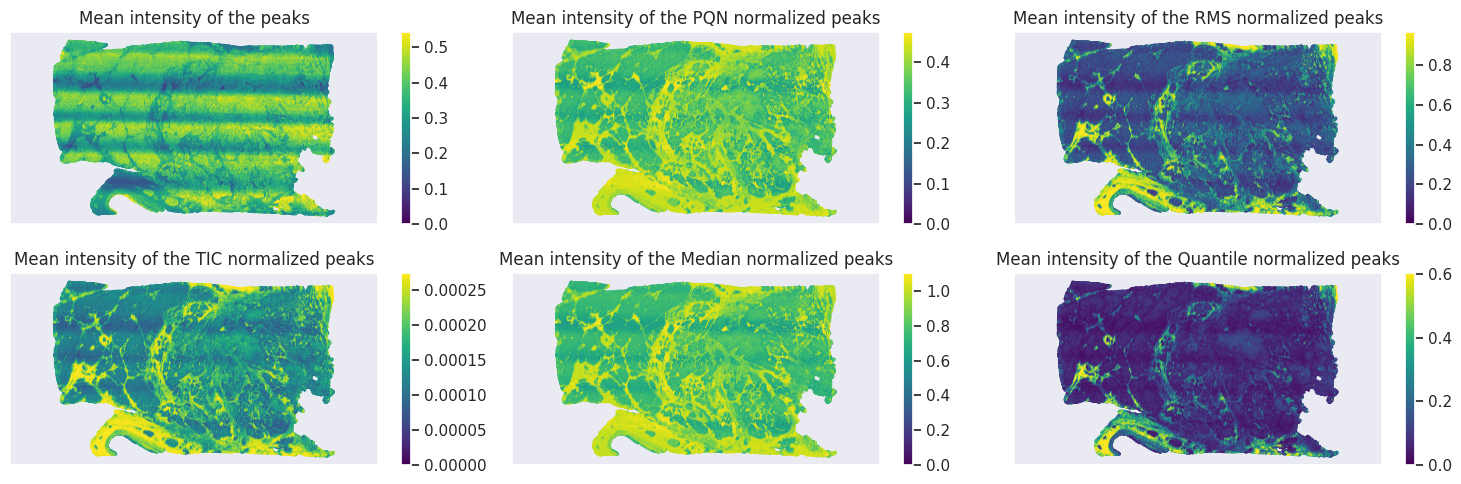

In [47]:
# Create the figure
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15, 5), tight_layout=True)

# Scatter the mean of the peaks
axs[0, 0].scatter(x=pixels_lame['x_warped'], y=pixels_lame['y_warped'], c=image, cmap='viridis', s=1, vmin=0, vmax=image.quantile(0.99))
axs[0, 0].set_title("Mean intensity of the peaks")

axs[0, 1].scatter(x=pixels_lame['x_warped'], y=pixels_lame['y_warped'], c=image_pqn, cmap='viridis', s=1, vmin=0, vmax=image_pqn.quantile(0.99))
axs[0, 1].set_title("Mean intensity of the PQN normalized peaks")

axs[0, 2].scatter(x=pixels_lame['x_warped'], y=pixels_lame['y_warped'], c=image_rms, cmap='viridis', s=1, vmin=0, vmax=image_rms.quantile(0.99))
axs[0, 2].set_title("Mean intensity of the RMS normalized peaks")

axs[1, 0].scatter(x=pixels_lame['x_warped'], y=pixels_lame['y_warped'], c=image_tic, cmap='viridis', s=1, vmin=0, vmax=image_tic.quantile(0.99))
axs[1, 0].set_title("Mean intensity of the TIC normalized peaks")

axs[1, 1].scatter(x=pixels_lame['x_warped'], y=pixels_lame['y_warped'], c=image_median, cmap='viridis', s=1, vmin=0, vmax=image_median.quantile(0.99))
axs[1, 1].set_title("Mean intensity of the Median normalized peaks")

axs[1, 2].scatter(x=pixels_lame['x_warped'], y=pixels_lame['y_warped'], c=image_quantile, cmap='viridis', s=1, vmin=0, vmax=image_quantile.quantile(0.99))
axs[1, 2].set_title("Mean intensity of the Quantile normalized peaks")

for ax in axs.flatten():
    ax.set_xticks([])
    ax.set_yticks([])
    ax.axis('equal')
    ax.invert_yaxis()
    fig.colorbar(ax.collections[0], ax=ax)

plt.show()

In [48]:
peaks_norm = maldi_normalize(peaks[pixels['run'] == lames[1]], method='RMS')

In [49]:
# Renormalize the PQN peaks
image_norm = peaks_norm.iloc[:, 2000:].mean(axis=1)
image_norm_pqn = maldi_normalize(peaks_norm, method='PQN').iloc[:, 2000:].mean(axis=1)
image_norm_rms = maldi_normalize(peaks_norm, method='RMS').iloc[:, 2000:].mean(axis=1)
image_norm_tic = maldi_normalize(peaks_norm, method='TIC').iloc[:, 2000:].mean(axis=1)
image_norm_median = maldi_normalize(peaks_norm, method='Median').iloc[:, 2000:].mean(axis=1)
image_norm_quantile = maldi_normalize(peaks_norm, method='Quantile').iloc[:, 2000:].mean(axis=1)

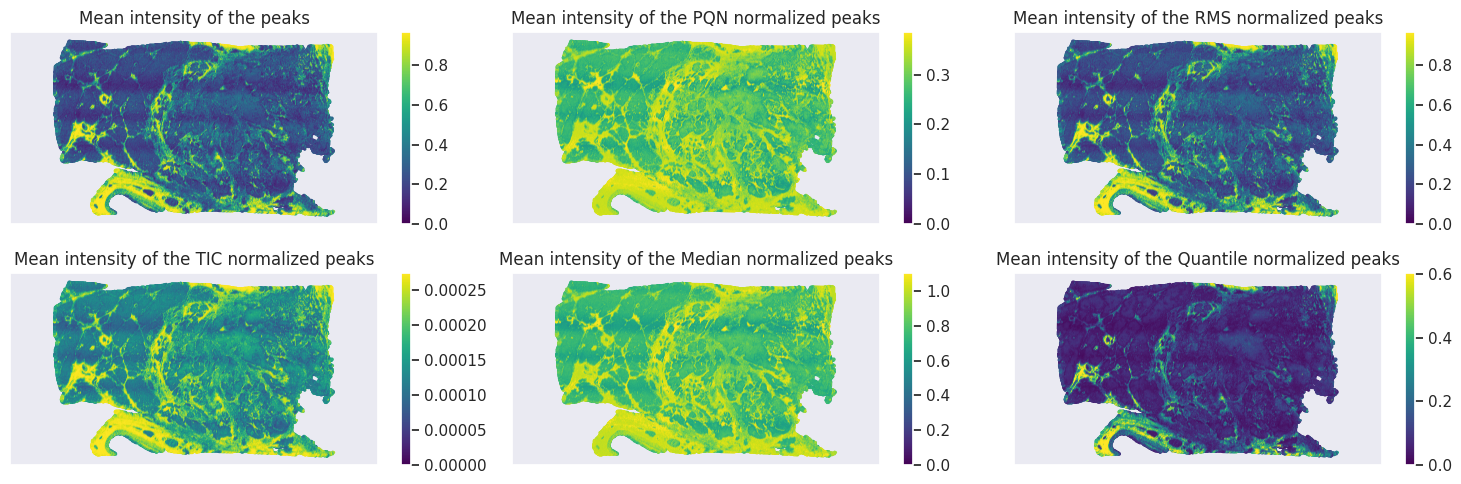

In [50]:
# Create the figure
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15, 5), tight_layout=True)

# Scatter the mean of the peaks
axs[0, 0].scatter(x=pixels_lame['x_warped'], y=pixels_lame['y_warped'], c=image_norm, cmap='viridis', s=1, vmin=0, vmax=image_norm.quantile(0.99))
axs[0, 0].set_title("Mean intensity of the peaks")

axs[0, 1].scatter(x=pixels_lame['x_warped'], y=pixels_lame['y_warped'], c=image_norm_pqn, cmap='viridis', s=1, vmin=0, vmax=image_norm_pqn.quantile(0.99))
axs[0, 1].set_title("Mean intensity of the PQN normalized peaks")

axs[0, 2].scatter(x=pixels_lame['x_warped'], y=pixels_lame['y_warped'], c=image_norm_rms, cmap='viridis', s=1, vmin=0, vmax=image_norm_rms.quantile(0.99))
axs[0, 2].set_title("Mean intensity of the RMS normalized peaks")

axs[1, 0].scatter(x=pixels_lame['x_warped'], y=pixels_lame['y_warped'], c=image_norm_tic, cmap='viridis', s=1, vmin=0, vmax=image_norm_tic.quantile(0.99))
axs[1, 0].set_title("Mean intensity of the TIC normalized peaks")

axs[1, 1].scatter(x=pixels_lame['x_warped'], y=pixels_lame['y_warped'], c=image_norm_median, cmap='viridis', s=1, vmin=0, vmax=image_norm_median.quantile(0.99))
axs[1, 1].set_title("Mean intensity of the Median normalized peaks")

axs[1, 2].scatter(x=pixels_lame['x_warped'], y=pixels_lame['y_warped'], c=image_norm_quantile, cmap='viridis', s=1, vmin=0, vmax=image_norm_quantile.quantile(0.99))
axs[1, 2].set_title("Mean intensity of the Quantile normalized peaks")

for ax in axs.flatten():
    ax.set_xticks([])
    ax.set_yticks([])
    ax.axis('equal')
    ax.invert_yaxis()
    fig.colorbar(ax.collections[0], ax=ax)

plt.show()

# Remove the Trypsin peaks

In [4]:
# Load the trypsin peaks from a file
with open("trypsin_peaks.yml", "r") as f:
    trypsin_masses = yaml.safe_load(f)

# Extract the trypsin peaks
trypsin_peaks = [peak for peak in peaks.columns if np.min(np.abs(float(peak) - np.array(trypsin_masses))) < 0.2]

print(f"Found {len(trypsin_peaks)} trypsin peaks")
for peak in trypsin_peaks:
    print(f"peak: {float(peak)}, mass: {trypsin_masses[np.argmin(np.abs(float(peak) - np.array(trypsin_masses)))]:.2f} ,diff: {np.min(np.abs(float(peak) - np.array(trypsin_masses))):.2f}")

Found 12 trypsin peaks
peak: 515.3292, mass: 515.33 ,diff: 0.00
peak: 842.476, mass: 842.51 ,diff: 0.03
peak: 906.3916, mass: 906.50 ,diff: 0.11
peak: 1006.4606, mass: 1006.49 ,diff: 0.03
peak: 1045.5339, mass: 1045.56 ,diff: 0.03
peak: 1469.6891, mass: 1469.73 ,diff: 0.04
peak: 1736.8208, mass: 1736.84 ,diff: 0.02
peak: 1768.823, mass: 1768.80 ,diff: 0.02
peak: 2158.0994, mass: 2158.03 ,diff: 0.07
peak: 2211.0896, mass: 2211.10 ,diff: 0.01
peak: 2283.1072, mass: 2283.18 ,diff: 0.07
peak: 3013.4917, mass: 3013.32 ,diff: 0.17


# Benchmark the different normalization methods

In [ ]:
# Benchmark the different normalization methods for the CD8 density prediction
results = []

for normalization_method in ['PQN', 'TIC', 'Mean', 'Median', 'RMS', 'MAX', 'Quantile']:
    
    print(f"{normalization_method} normalization")
    
    # Normalize the peaks
    peaks_norm = peaks.copy()
    for lame in lames:
        peaks_norm.loc[pixels['run'] == lame] = maldi_normalize(peaks=peaks[pixels['run'] == lame],
                                                                method=normalization_method)
    
    # Exclude the non lesion pixels
    peaks_norm_lesion = peaks_norm[pixels['Density_Lesion'] > 0.5]
    pixels_lesion = pixels[pixels['Density_Lesion'] > 0.5]

    # Create a linear regression model
    model_reg = LinearRegression()
    
    # Train the model
    model_reg.fit(peaks_norm_lesion.values, pixels_lesion['Density_CD8'].values)

    # Calculate the R2 score
    r2 = model_reg.score(peaks_norm_lesion.values, pixels_lesion['Density_CD8'].values)

    # Predict the CD8 density
    y_pred = model_reg.predict(peaks_norm_lesion.values)

    # Compute the mean squared error
    mse = mean_squared_error(pixels_lesion['Density_CD8'].values, y_pred)

    # Calculate the pearson correlation
    pearson_correlation = np.corrcoef(pixels_lesion['Density_CD8'].values, y_pred)[0, 1]

    print(f"R2: {r2:.4f}, MSE: {mse:.4f}, Pearson Correlation: {pearson_correlation:.4f}")

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(peaks_norm_lesion.values, pixels_lesion['Density_CD8'].values,
                                                        test_size=0.1,
                                                        random_state=42)
    
    # Adjust the y values to be binary
    y_train = y_train > threshold['Density_CD8']
    y_test = y_test > threshold['Density_CD8']

    # Create a logistic regression model
    model_log = LogisticRegression(max_iter=10**6, class_weight='balanced')

    # Train the model
    model_log.fit(X_train, y_train)

    # Make predictions
    y_pred = model_log.predict(X_test)

    # Compute the accuracy using accuracy_score
    accuracy_train = model_log.score(X_train, y_train)
    accuracy_test = accuracy_score(y_test, y_pred)

    # Compute the IOU
    iou_train = jaccard_score(y_train, model_log.predict(X_train))
    iou_test = jaccard_score(y_test, y_pred)

    # Compute the AUC
    auc_train = roc_auc_score(y_train, model_log.predict_proba(X_train)[:, 1])
    auc_test = roc_auc_score(y_test, model_log.predict_proba(X_test)[:, 1])

    print(f"Accuracy (train): {accuracy_train:.4f}, Accuracy (test): {accuracy_test:.4f}")
    print(f"IOU (train): {iou_train:.4f}, IOU (test): {iou_test:.4f}")
    print(f"AUC (train): {auc_train:.4f}, AUC (test): {auc_test:.4f}")

    # Append the results to the list
    results.append({
        'Normalization': normalization_method,
        'R2': r2,
        'MSE': mse,
        'Pearson Correlation': pearson_correlation,
        'Accuracy (train)': accuracy_train,
        'Accuracy (test)': accuracy_test,
        'IOU (train)': iou_train,
        'IOU (test)': iou_test,
        'AUC (train)': auc_train,
        'AUC (test)': auc_test
    })

# Convert the results to a DataFrame
results_df = pd.DataFrame(results)
results_df

PQN normalization
R2: 0.2081, MSE: 0.0008, Pearson Correlation: 0.4562
Accuracy (train): 0.7875, Accuracy (test): 0.7834
IOU (train): 0.2572, IOU (test): 0.2516
AUC (train): 0.8844, AUC (test): 0.8704
TIC normalization
R2: 0.1935, MSE: 0.0008, Pearson Correlation: 0.4399
Accuracy (train): 0.6844, Accuracy (test): 0.6871
IOU (train): 0.1702, IOU (test): 0.1745
AUC (train): 0.7761, AUC (test): 0.7787
Mean normalization
R2: 0.1935, MSE: 0.0008, Pearson Correlation: 0.4399
Accuracy (train): 0.7875, Accuracy (test): 0.7829
IOU (train): 0.2597, IOU (test): 0.2529
AUC (train): 0.8884, AUC (test): 0.8744
Median normalization
R2: 0.1954, MSE: 0.0008, Pearson Correlation: 0.4421
Accuracy (train): 0.7867, Accuracy (test): 0.7822
IOU (train): 0.2583, IOU (test): 0.2520
AUC (train): 0.8886, AUC (test): 0.8767
RMS normalization
R2: 0.1778, MSE: 0.0008, Pearson Correlation: 0.4216
Accuracy (train): 0.7832, Accuracy (test): 0.7792
IOU (train): 0.2558, IOU (test): 0.2510
AUC (train): 0.8851, AUC (test)

,Normalization,R2,MSE,Pearson Correlation,Accuracy (train),Accuracy (test),IOU (train),IOU (test),AUC (train),AUC (test)
0,PQN,0.208086,0.000781,0.456165,0.787512,0.783380,0.257161,0.251631,0.884413,0.870429
1,TIC,0.193524,0.000795,0.439914,0.684441,0.687064,0.170191,0.174477,0.776089,0.778726
2,Mean,0.193524,0.000795,0.439914,0.787490,0.782908,0.259661,0.252933,0.888446,0.874354
3,Median,0.195427,0.000793,0.442072,0.786661,0.782174,0.258292,0.251981,0.888573,0.876652
4,RMS,0.177782,0.000811,0.421642,0.783193,0.779202,0.255816,0.250993,0.885086,0.867640
5,MAX,0.167523,0.000821,0.409296,0.778638,0.777034,0.252040,0.251277,0.881892,0.867270
6,Quantile,0.166789,0.000821,0.408398,0.781033,0.777209,0.254289,0.249750,0.883327,0.864779


In [12]:
# Save the results to a file
results_df.to_csv("data/CD8_density_prediction.csv", index=False)

In [26]:
# Extract the peaks for the lesion pixels
peaks_lesion = peaks[pixels['Density_Lesion'] > 0.5].reset_index(drop=True)

# Extract the normalized peaks for the lesion pixels
peaks_norm_lesion = peaks_norm[pixels['Density_Lesion'] > 0.5].reset_index(drop=True)

In [ ]:
# Save the normalized peaks to feather
peaks_norm.to_feather("data/mse_conc_peaks_normalized_complete.feather")
peaks_norm_lesion.to_feather("data/mse_conc_peaks_normalized.feather")